In [ ]:
# first lets read in scipy, as I'll need the "curve_fit" function in optimize
from __future__ import print_function

import numpy as np
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import comb
import math
import sys
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize

# now the DCIS count data is found in an RDA file, which we apparently read using 'pyreadr'

import pyreadr

# to convert Ensemble to Refseq gene names
gene_convert = pyreadr.read_r('/path/to/ensemble_to_refseq_gene_name_table.rds')
gene_convert = gene_convert[None]
id_to_name = {gene_id: gene_name for gene_id, gene_name in zip(gene_convert["gene_id"], gene_convert["gene_name"])}


# and a function I use in the document
def variance_mean(row):
    variance = np.var(row, ddof=1) # “Delta Degrees of Freedom”
    mean = np.mean(row)
    std_dev = np.sqrt(variance) # sometimes this is considered dispersion
    
    # I'm a bit confused exactly how I'd compute a dataset-wide dispersion from this data
    # the formula given is Variance = mean + dispersion*mean^2
    # re-arranged, this gives dispersion = (variance - mean)/(mean*mean)
    # I guess we can try it
    dispersion = 0 # in case the mean is zero, or if variance = mean
    if ((mean != 0) & (variance != mean)):
        #dispersion = (variance - mean)/(mean**2)
        dispersion = (mean**2)/(variance - mean) # did I have this backwards?
        inverse_dispersion = dispersion**-1
    
    # and they define "expected fraction zeros" as exp(-mean) - Poisson distribution!
    #prob_frac = math.exp(mean*-1)
    
    # lets do the NB formulation
    prob_frac = 1 # if dispersion is zero, the fraction zero is 100%
    if (dispersion >0):
        prob_frac = ((inverse_dispersion)/(mean + inverse_dispersion))**(inverse_dispersion)
    
    # we will also want to know the fraction of the row that equals zero
    zero_frac = (row == 0).sum()/len(row)
    return pd.Series({'variance': variance, 'mean': mean, "StDev": std_dev, "Dispersion": dispersion, 'zero_fraction': zero_frac, 'prob_frac': prob_frac})

In [22]:
# lets begin with dataset - ≈

In [ ]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq

data = pd.read_csv('/path/to/Third_Party_FFPE/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)

# filtering non-count data
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

# now we compute dispersion
TUMOR_dispersion = tumours_counts.apply(variance_mean, axis=1)


In [25]:
print(TUMOR_dispersion)

           variance         mean        StDev    Dispersion  zero_fraction  \
0      4.330463e+04   373.098485   208.097640  3.242430e+00       0.000000   
1      1.591450e+05   592.121212   398.929845  2.211297e+00       0.000000   
2      5.329649e+03    99.274621    73.004447  1.884272e+00       0.000000   
3      3.035265e+06  2601.520833  1742.201224  2.231672e+00       0.000000   
4      2.483556e+03    84.638258    49.835287  2.986195e+00       0.000000   
...             ...          ...          ...           ...            ...   
43656  1.893939e-03     0.001894     0.043519 -1.946135e+11       0.998106   
43657  4.283466e-02     0.028409     0.206965  5.594765e-02       0.977273   
43658  1.893939e-03     0.001894     0.043519 -1.413859e+11       0.998106   
43659  1.512244e+00     0.657197     1.229733  5.051275e-01       0.617424   
43660  1.893939e-03     0.001894     0.043519 -3.308429e+12       0.998106   

       prob_frac  
0       0.111983  
1       0.038926  
2     

GSE167977 fit to an NB


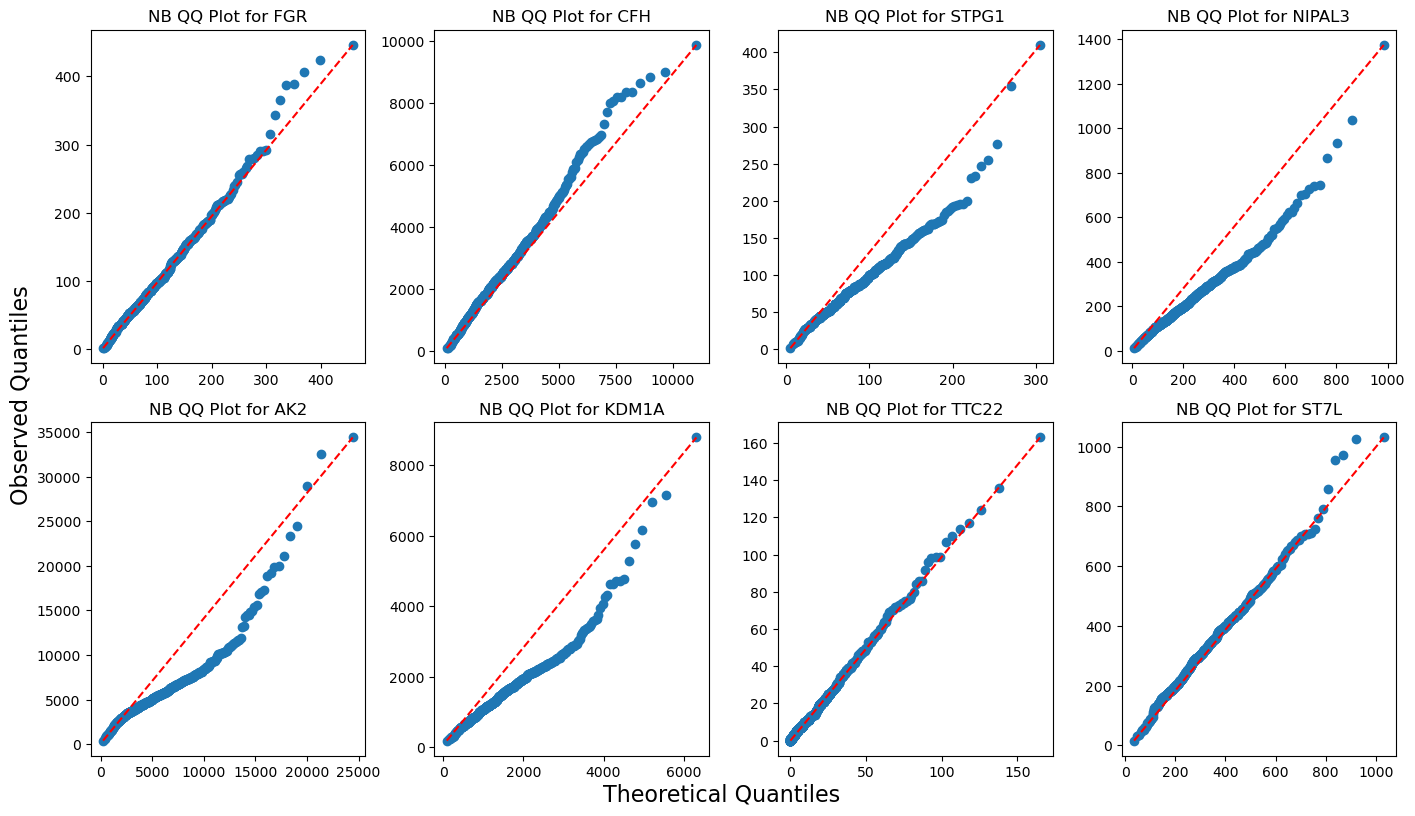

In [26]:
# lets make QQ Plots of genes, comparing gene expression with an NB
fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(2, 10)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = tumours_counts.iloc[gene_pos, :]
    gene_name = data.iloc[gene_pos, 0]
    
    sorted_data = np.sort(observed_random_gene)
    sorted_data = sorted_data[:-1]

    # change Ensemble gene name to RefSeq
    converted_gene_name = id_to_name[gene_name]

    # calculate r and p from this gene
    # Estimate the parameters r and p using method of moments
    mean_gene_expression = np.mean(sorted_data)
    var_gene_expression = np.var(sorted_data)
    p = mean_gene_expression / var_gene_expression
    r = mean_gene_expression**2 / (var_gene_expression - mean_gene_expression)

    # Sort the observed data
    

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles
    theoretical_quantiles = stats.nbinom.ppf(observed_quantiles, r, p)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'NB QQ Plot for {converted_gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()

print("GSE167977 fit to an NB")

plt.show()


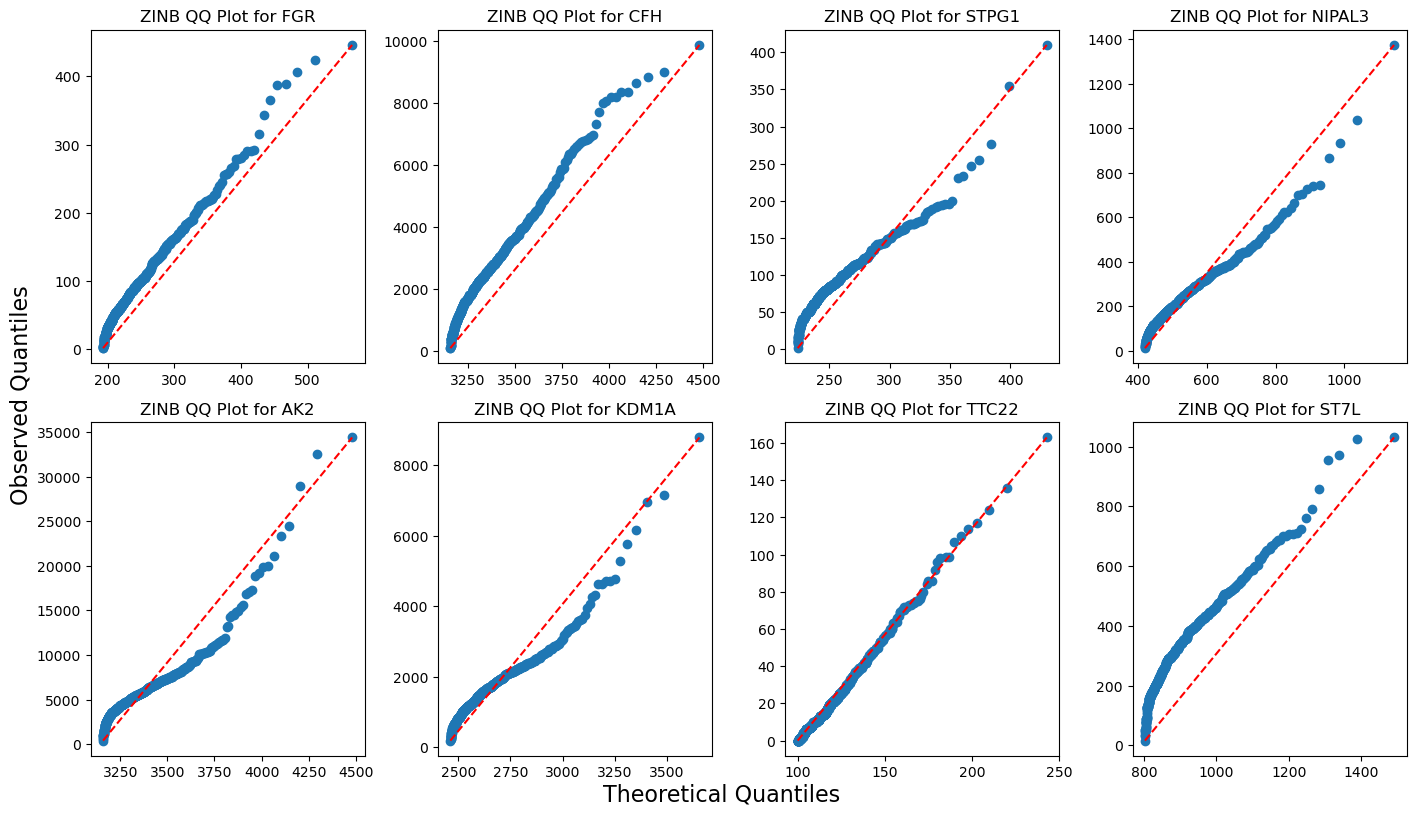

In [61]:
# using Maximum Likelihood Estimation (MLE) to compute ZINB
from scipy.optimize import minimize


def nll_zinb(params, data):
    r, p, pi = params
    nb_term = stats.nbinom.logpmf(data[data > 0], r, p)
    zero_term = np.log((1 - pi) + pi * stats.nbinom.pmf(0, r, p))
    nll = -np.sum(nb_term) - np.sum(zero_term)
    return nll

fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(2, 10)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = tumours_counts.iloc[gene_pos, :]
    gene_name = data.iloc[gene_pos, 0]

    # change Ensemble gene name to RefSeq
    converted_gene_name = id_to_name[gene_name]
    
    sorted_data = np.sort(observed_random_gene)
    sorted_data = sorted_data[:-1]
    
    # Initial guesses for r, p, and pi
    initial_guess = [1, 0.5, 0.1]
    
    # Bounds for r, p, and pi
    bounds = [(0.01, 20), (0.01, 0.99), (0.01, 0.99)]

    result = minimize(nll_zinb, initial_guess, args=(sorted_data,), bounds=bounds)
    r_mle, p_mle, pi_mle = result.x

    

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles with ZINB parameters
    # Zero-inflation will affect the lower quantiles; we need to adjust for this.
    adjusted_quantiles = (1 - pi_mle) + pi_mle * observed_quantiles
    theoretical_quantiles = stats.nbinom.ppf(adjusted_quantiles, r_mle, p_mle)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'ZINB QQ Plot for {converted_gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()
print("GSE167977 fit to an ZINB")
plt.show()



In [ ]:
# lets do another 3rd party - GSE181466

In [ ]:
# all FFPE breast tumours, different treatment (not split up)
import pandas as pd

data = pd.read_csv('/path/to/Third_Party_FFPE/Additional_Sets/GSE181466_rsem_genes_matrix-97.txt',
                  delimiter='\t')

# patient information splitting is unnecessary, this appears to all be both FFPE and from tumours
# there is subtype and age information in the series matrix file, if we're interested

# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# removing gene column at position 0
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1)
column_sums = np.sum(tumours_counts, axis=0)
TUMOR_dispersion = tumours_counts.apply(variance_mean, axis=1)

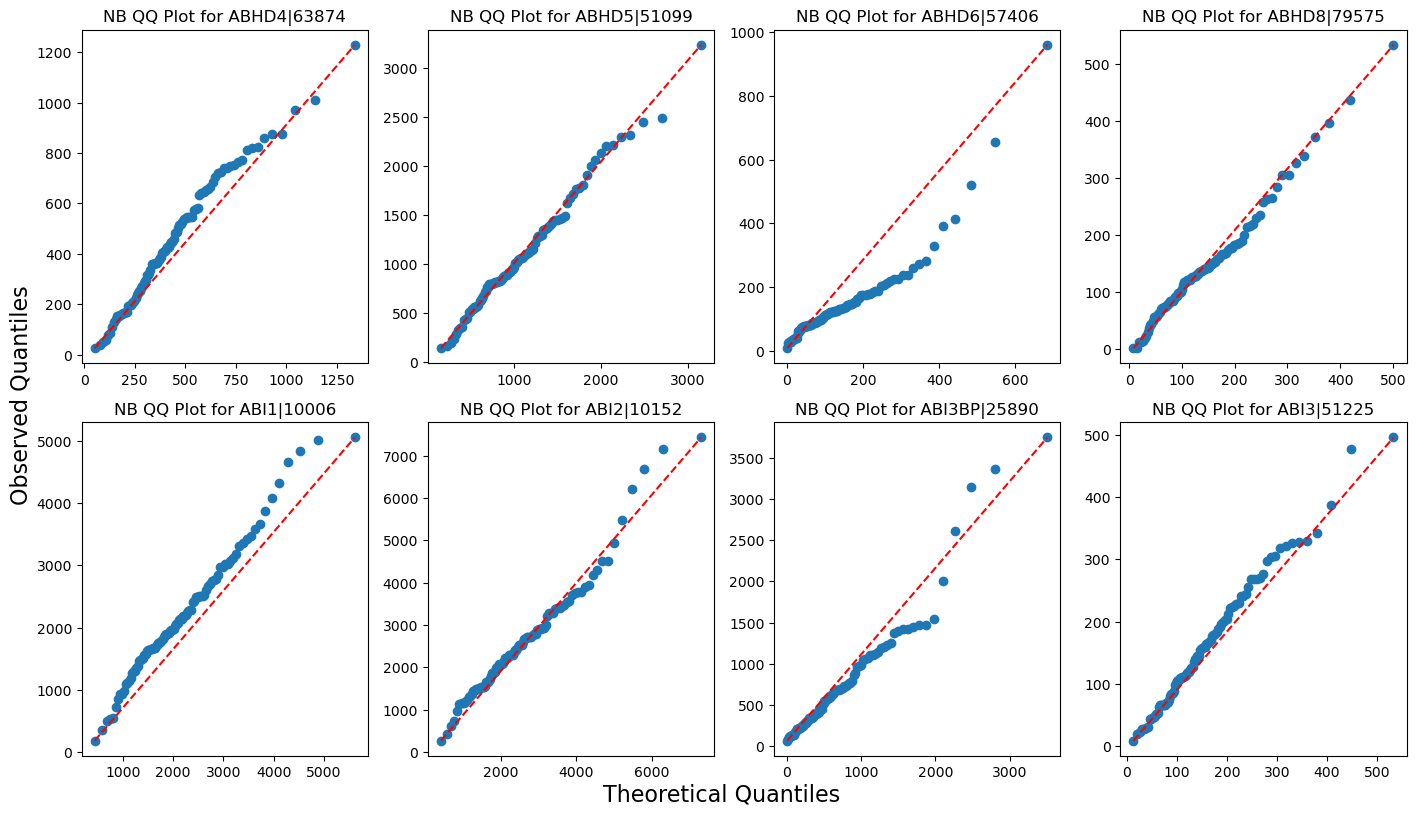

In [75]:
# lets make QQ Plots of genes, comparing gene expression with an NB
fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(120, 128)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = tumours_counts.iloc[gene_pos, :]
    gene_name = data.iloc[gene_pos, 0]
    
    sorted_data = np.sort(observed_random_gene)
    sorted_data = sorted_data[:-1]

    # calculate r and p from this gene
    # Estimate the parameters r and p using method of moments
    mean_gene_expression = np.mean(sorted_data)
    var_gene_expression = np.var(sorted_data)
    p = mean_gene_expression / var_gene_expression
    r = mean_gene_expression**2 / (var_gene_expression - mean_gene_expression)

    # Sort the observed data
    

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles
    theoretical_quantiles = stats.nbinom.ppf(observed_quantiles, r, p)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'NB QQ Plot for {gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()
plt.show()

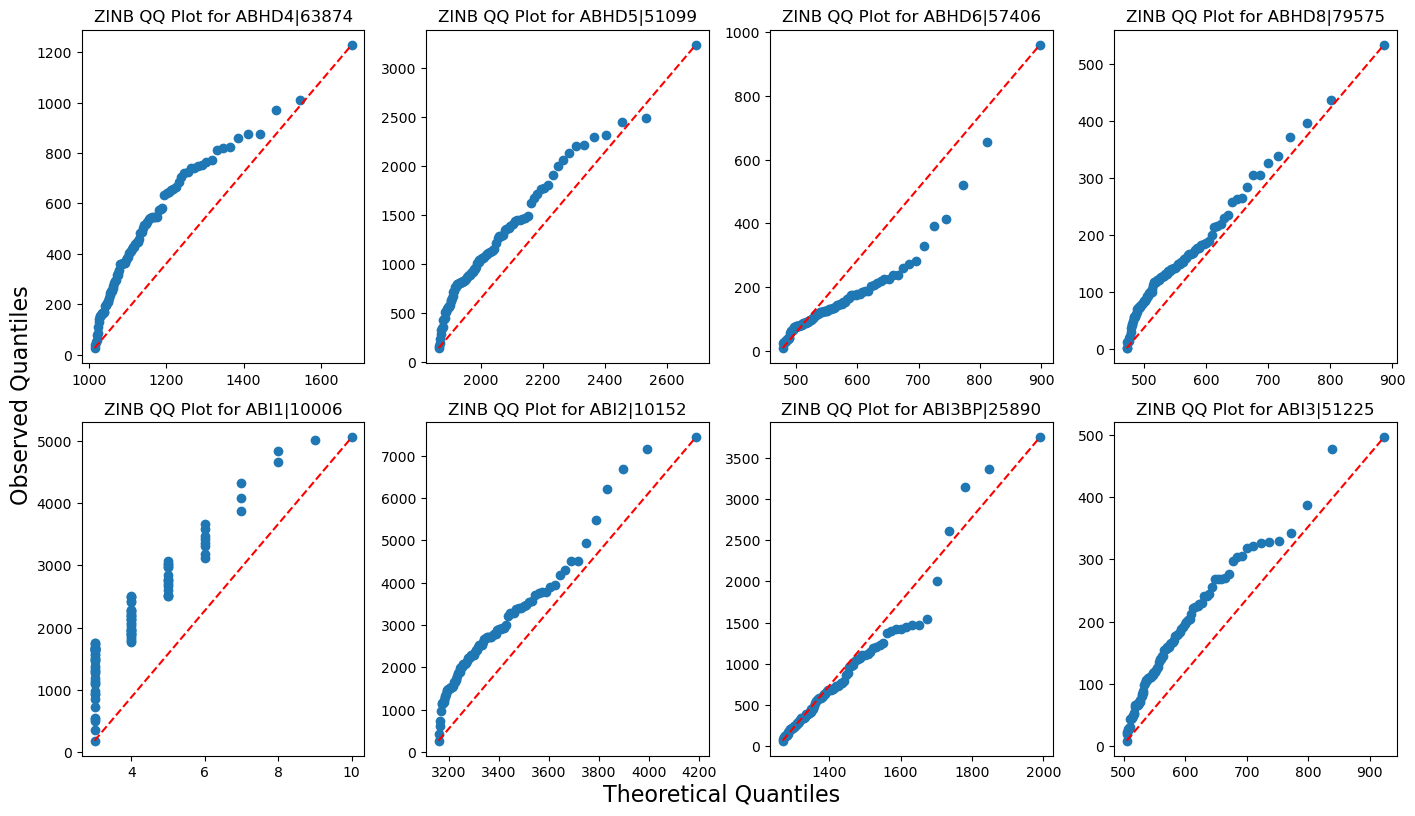

In [76]:
def nll_zinb(params, data):
    r, p, pi = params
    nb_term = stats.nbinom.logpmf(data[data > 0], r, p)
    zero_term = np.log((1 - pi) + pi * stats.nbinom.pmf(0, r, p))
    nll = -np.sum(nb_term) - np.sum(zero_term)
    return nll

fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(120, 128)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = tumours_counts.iloc[gene_pos, :]
    gene_name = data.iloc[gene_pos, 0]
    
    sorted_data = np.sort(observed_random_gene)
    sorted_data = sorted_data[:-1]
    
    # Initial guesses for r, p, and pi
    initial_guess = [1, 0.5, 0.1]
    
    # Bounds for r, p, and pi
    bounds = [(0.01, 20), (0.01, 0.99), (0.01, 0.99)]

    result = minimize(nll_zinb, initial_guess, args=(sorted_data,), bounds=bounds)
    r_mle, p_mle, pi_mle = result.x

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles with ZINB parameters
    # Zero-inflation will affect the lower quantiles; we need to adjust for this.
    adjusted_quantiles = (1 - pi_mle) + pi_mle * observed_quantiles
    theoretical_quantiles = stats.nbinom.ppf(adjusted_quantiles, r_mle, p_mle)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'ZINB QQ Plot for {gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()
plt.show()

In [ ]:
# Interestingly, the ZINB is failing here, NB looks way better
# There does seem to be low expressed genes that look terrible though


In [ ]:
# Our dataset!
all_counts = pyreadr.read_r('/path/to/expression_counts.Jan2023_1_2_and_2_2.rds')
vst_norm = pyreadr.read_r('/path/to/expression_VST_Normalized.Jan2023_1_2_and_2_2.rds')

# this data is loading without issue
ship_data = pyreadr.read_r('/path/to/ship1_2_full_tbl.Jan2023.With_Stroma_Assignment.rds')
# I wish that we could've simply used the RDA, but the counts-only RDS works and loads faster so what can you do
# in the future, could try the package 'rpy2' instead, it's an alternative that requires R but that's okay for us

# to do: import Ensemble to Refseq gene name conversion table to fix that
gene_convert = pyreadr.read_r('/path/to/ensemble_to_refseq_gene_name_table.rds')


# now we want to isolate just the expression from a particular type of tissue
df = all_counts[None] # load all_counts into a pandas data frame

# Eliminate any samples in the blacklist
ship_df = ship_data[None]
#print(ship_df['blacklist'].value_counts()) # they're all false

# since ship_data already has patients filtered out, lets filter out any patient who isn't on the list
# match by 'sample_name'
df_blacklist_filtered = df[ship_df['sample_name']]

# split the patients by tissue
count_DCIS = df_blacklist_filtered.filter(like='_D')
count_STROMA = df_blacklist_filtered.filter(like='_S')
count_NORMAL = df_blacklist_filtered.filter(like='_N')
# we will perform all our work from this point on with Normal tissues for now

# I also want gene_convert to be a pandas data frame
gene_convert = gene_convert[None]


In [28]:
# I want to add a new count table, averaged by the number of reads in the entire sample
column_sums = np.sum(count_NORMAL, axis=0)

# Divide each element by the column sum
count_NORMAL_libsizeadjust = count_NORMAL / column_sums

column_sums = np.sum(count_STROMA, axis=0)
count_STROMA_libsizeadjust = count_STROMA / column_sums


column_sums = np.sum(count_DCIS, axis=0)
count_DCIS_libsizeadjust = count_DCIS / column_sums

In [29]:
# now we have to filter out any genes that were eliminated when we did VST normalization
vst_table = vst_norm[None] # we don't apply this anymore because it blocks any gene with >80% frac_zero
filtered_count = count_NORMAL[count_NORMAL.index.isin(vst_table.index)]

#print(filtered_count) # looks like it worked, rows reduced to 23203 as expected

# converting Ensemble names to gene name
#count_NORMAL = filtered_count.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))

# removed filter from VST, I realize now it removed anything with >80% fraction zero
# thus it isn't a strong representation of the data
count_NORMAL = count_NORMAL.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
#print(count_NORMAL)

# we should filter out anything that is an Ensemble ID, so anything that starts "ENSG0"
pattern = '^ENSG0'
count_NORMAL = count_NORMAL[~count_NORMAL.index.str.match(pattern)]

# I found rounding makes a difference in the plots, shifting it slightly right
#count_NORMAL = count_NORMAL.round(0)
#print(count_NORMAL)

count_NORMAL_libsizeadjust = count_NORMAL_libsizeadjust.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
#print(count_NORMAL)

# we should filter out anything that is an Ensemble ID, so anything that starts "ENSG0"
count_NORMAL_libsizeadjust = count_NORMAL_libsizeadjust[~count_NORMAL_libsizeadjust.index.str.match(pattern)]

#print(count_NORMAL_libsizeadjust)

count_STROMA = count_STROMA.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
count_STROMA = count_STROMA[~count_STROMA.index.str.match(pattern)]

count_DCIS = count_DCIS.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
count_DCIS = count_DCIS[~count_DCIS.index.str.match(pattern)]


count_STROMA_libsizeadjust = count_STROMA_libsizeadjust.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
count_STROMA_libsizeadjust = count_STROMA_libsizeadjust[~count_STROMA_libsizeadjust.index.str.match(pattern)]
count_DCIS_libsizeadjust = count_DCIS_libsizeadjust.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))
count_DCIS_libsizeadjust = count_DCIS_libsizeadjust[~count_DCIS_libsizeadjust.index.str.match(pattern)]


In [30]:
print(count_DCIS.index[0])

OR4F16


DCIS-Precise Tumour against NB


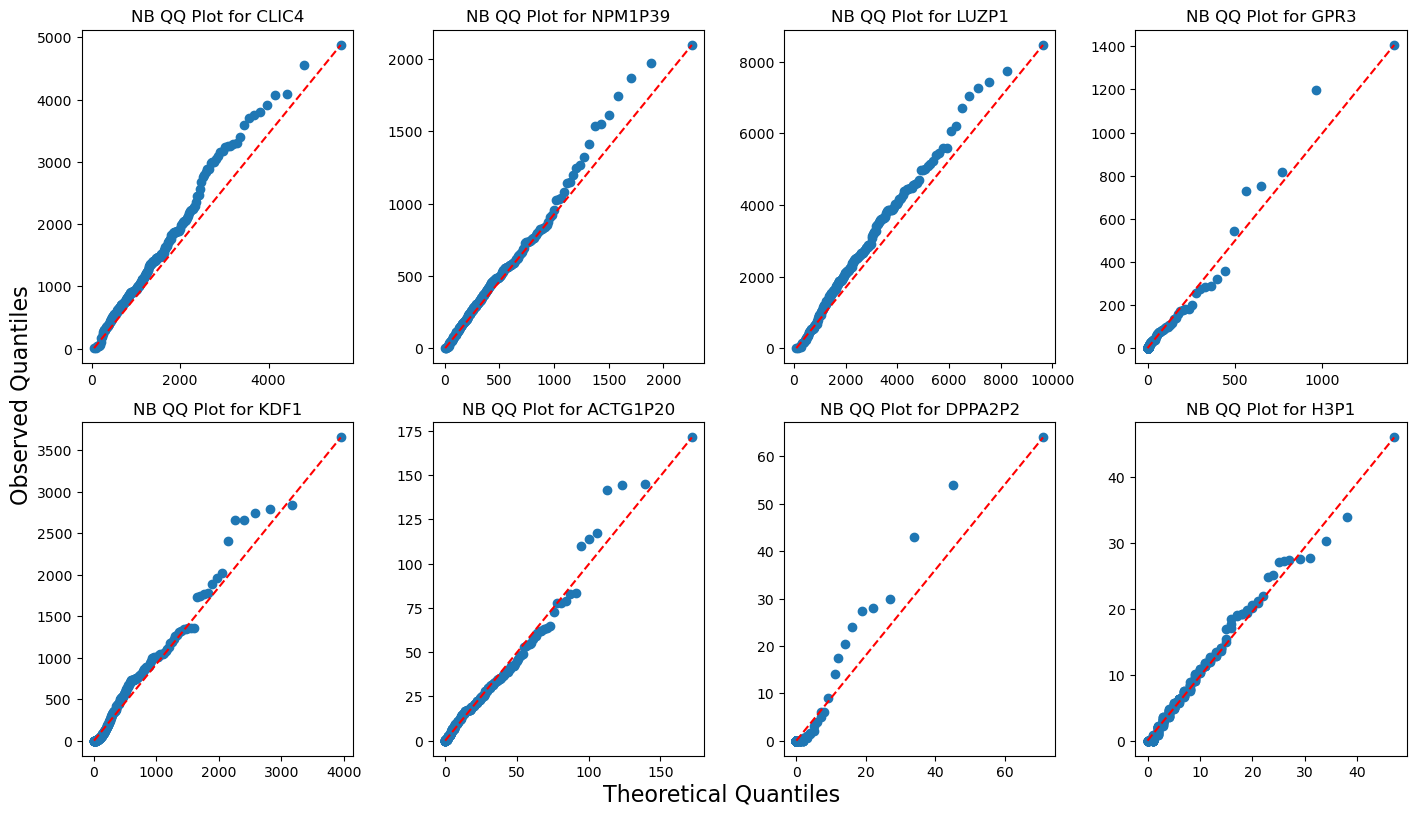

In [31]:
# lets make QQ Plots of genes, comparing gene expression with an NB
fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(140, 160)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = count_DCIS.iloc[gene_pos, :] # get counts for gene
    gene_name = count_DCIS.index[gene_pos] # get gene name (already converted to RefSeq)
    
    sorted_data = np.sort(observed_random_gene)
    sorted_data = sorted_data[:-1]
    sorted_data = sorted_data[:-1]

    if (max(sorted_data) < 10):
        continue

    # calculate r and p from this gene
    # Estimate the parameters r and p using method of moments
    mean_gene_expression = np.mean(sorted_data)
    var_gene_expression = np.var(sorted_data)
    p = mean_gene_expression / var_gene_expression
    r = mean_gene_expression**2 / (var_gene_expression - mean_gene_expression)

    # Sort the observed data
    

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles
    theoretical_quantiles = stats.nbinom.ppf(observed_quantiles, r, p)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'NB QQ Plot for {gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
        
        if (y_plot_order == 2):
            break
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()
print("DCIS-Precise Tumour against NB")
plt.show()

/home/emucaki/.conda/envs/ffpe_env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


DCIS-Precise Tumour against ZINB


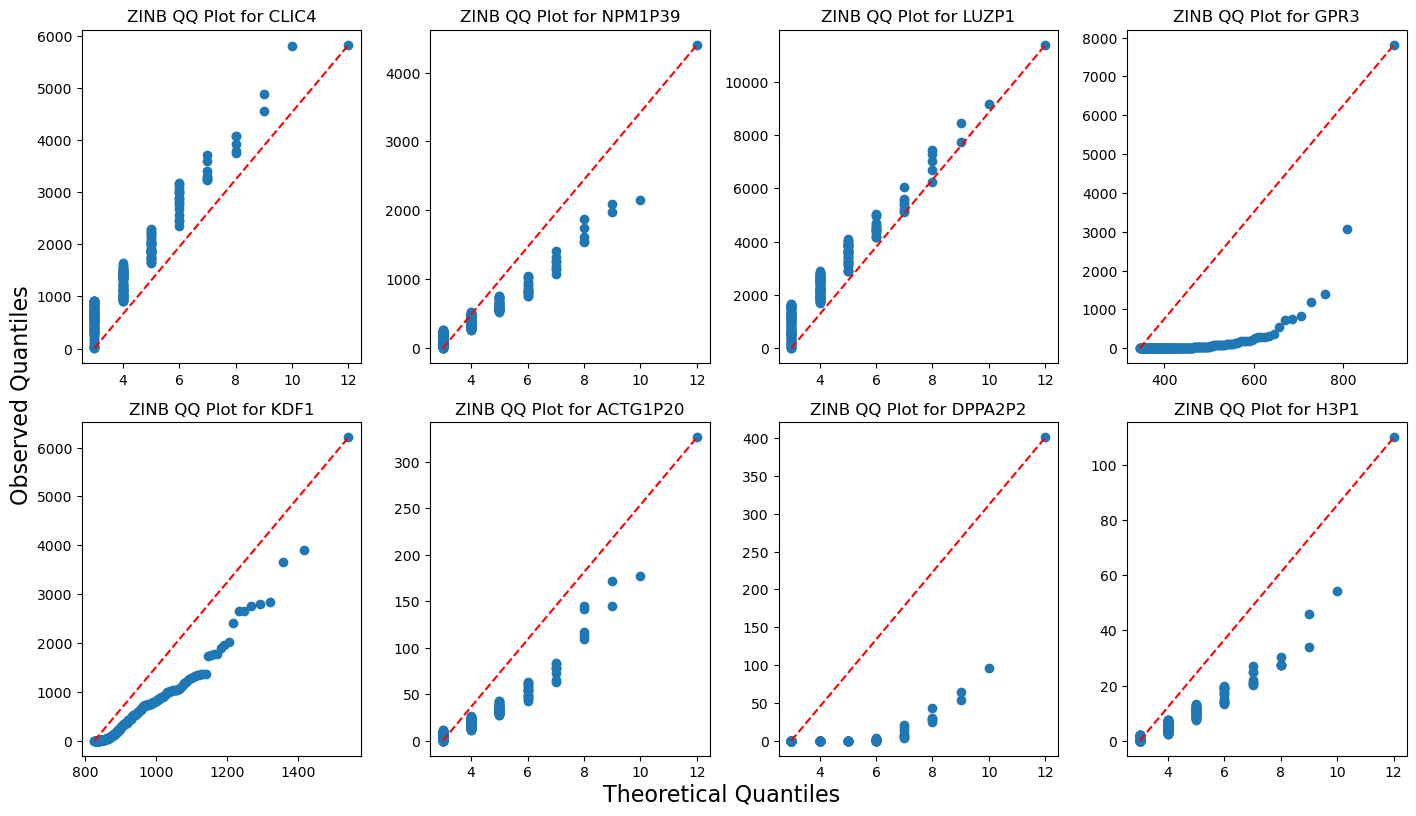

In [32]:
def nll_zinb(params, data):
    r, p, pi = params
    nb_term = stats.nbinom.logpmf(data[data > 0], r, p)
    zero_term = np.log((1 - pi) + pi * stats.nbinom.pmf(0, r, p))
    nll = -np.sum(nb_term) - np.sum(zero_term)
    return nll

fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
gene_list = range(140, 160)

x_plot_order = 0
y_plot_order = 0

for gene_pos in gene_list:
    observed_random_gene = count_DCIS.iloc[gene_pos, :] # get counts for gene
    gene_name = count_DCIS.index[gene_pos] # get gene name (already converted to RefSeq)
    
    sorted_data = np.sort(observed_random_gene)
    #sorted_data = sorted_data[:-1]
    #sorted_data = sorted_data[:-1]

    if (max(sorted_data) < 10):
        continue
    
    # Initial guesses for r, p, and pi
    initial_guess = [1, 0.5, 0.1]
    
    # Bounds for r, p, and pi
    bounds = [(0.01, 20), (0.01, 0.99), (0.01, 0.99)]

    result = minimize(nll_zinb, initial_guess, args=(sorted_data,), bounds=bounds)
    r_mle, p_mle, pi_mle = result.x

    # Calculate observed quantiles
    observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

    # Calculate theoretical quantiles with ZINB parameters
    # Zero-inflation will affect the lower quantiles; we need to adjust for this.
    adjusted_quantiles = (1 - pi_mle) + pi_mle * observed_quantiles
    theoretical_quantiles = stats.nbinom.ppf(adjusted_quantiles, r_mle, p_mle)

    # Create the Q-Q plot
    axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
    axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

    axs[y_plot_order][x_plot_order].set_title(f'ZINB QQ Plot for {gene_name}')
    x_plot_order = x_plot_order + 1
    
    if (x_plot_order == 4):
        x_plot_order = 0
        y_plot_order = y_plot_order + 1
        
        # stop once the plot is out of space
        if (y_plot_order == 2):
            break
    
fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

plt.tight_layout()
print("DCIS-Precise Tumour against ZINB")
plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def qqplot_exp(data):
    # Initialize the subplot grid
    fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
    x_plot_order = 0
    y_plot_order = 0

    # Loop through genes and create QQ plots
    for gene_pos in range(2, 10):  # Adjust the range based on the number of genes you have
        observed_random_gene = data.iloc[gene_pos, :]
        gene_name = data.index[gene_pos]
        sorted_data = np.sort(observed_random_gene)
        sorted_data = sorted_data[:-1]
        sorted_data = sorted_data[:-1]

        # Estimate the rate parameter λ (lambda) for the exponential distribution
        lambda_est = 1 / np.mean(sorted_data)

        # Calculate observed quantiles
        observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])

        # Calculate theoretical quantiles for the exponential distribution
        theoretical_quantiles = stats.expon.ppf(observed_quantiles, scale=1/lambda_est)

        # Create the QQ plot
        ax = axs[y_plot_order][x_plot_order]
        ax.scatter(theoretical_quantiles, sorted_data, label=f'Gene {gene_pos}')
        ax.plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

        ax.set_title(f'Exponential QQ Plot: {gene_name}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
     
        # Update subplot positions
        x_plot_order += 1
        if (x_plot_order == 4):
            x_plot_order = 0
            y_plot_order = y_plot_order + 1

    # Show the plots
    plt.tight_layout()
    plt.show()

In [93]:

def qqplot_nb(data):
    # lets make QQ Plots of genes, comparing gene expression with an NB
    fig, axs = plt.subplots(2, 4, figsize=(14, 8))  # num_of_genes is the number of genes you want to plot
    gene_list = range(2, 10)

    x_plot_order = 0
    y_plot_order = 0

    for gene_pos in gene_list:
        observed_random_gene = data.iloc[gene_pos, :]
        gene_name = data.index[gene_pos]
        sorted_data = np.sort(observed_random_gene)
        sorted_data = sorted_data[:-1]
        sorted_data = sorted_data[:-1]
            
        # calculate r and p from this gene
        # Estimate the parameters r and p using method of moments
        mean_gene_expression = np.mean(sorted_data)
        var_gene_expression = np.var(sorted_data)
        p = mean_gene_expression / var_gene_expression
        r = mean_gene_expression**2 / (var_gene_expression - mean_gene_expression)

        # Calculate observed and theoretical quantiles
        observed_quantiles = np.array([(i - 0.5) / len(sorted_data) for i in range(1, len(sorted_data) + 1)])
        theoretical_quantiles = stats.nbinom.ppf(observed_quantiles, r, p)

        # Create the Q-Q plot
        axs[y_plot_order][x_plot_order].scatter(theoretical_quantiles, sorted_data)
        axs[y_plot_order][x_plot_order].plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(sorted_data), max(sorted_data)], 'r--')

        axs[y_plot_order][x_plot_order].set_title(f'NB QQ Plot: {gene_name}')
        x_plot_order = x_plot_order + 1
    
        if (x_plot_order == 4):
            x_plot_order = 0
            y_plot_order = y_plot_order + 1
    
    fig.text(0.5, 0.00, 'Theoretical Quantiles', ha='center', va='center', size = 16)
    fig.text(0.00, 0.5, 'Observed Quantiles', ha='center', va='center', rotation='vertical', size=16)

    plt.tight_layout()
    plt.show()


In [ ]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq

data = pd.read_csv('/path/to/Third_Party_FFPE/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# set genes as row name
tumours_counts = tumours_counts.set_index('ensembl_gene_id')
tumours_counts = tumours_counts.rename(index=dict(zip(gene_convert["gene_id"], gene_convert["gene_name"])))

# filtering non-count data
#tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns



NB: GSE167977


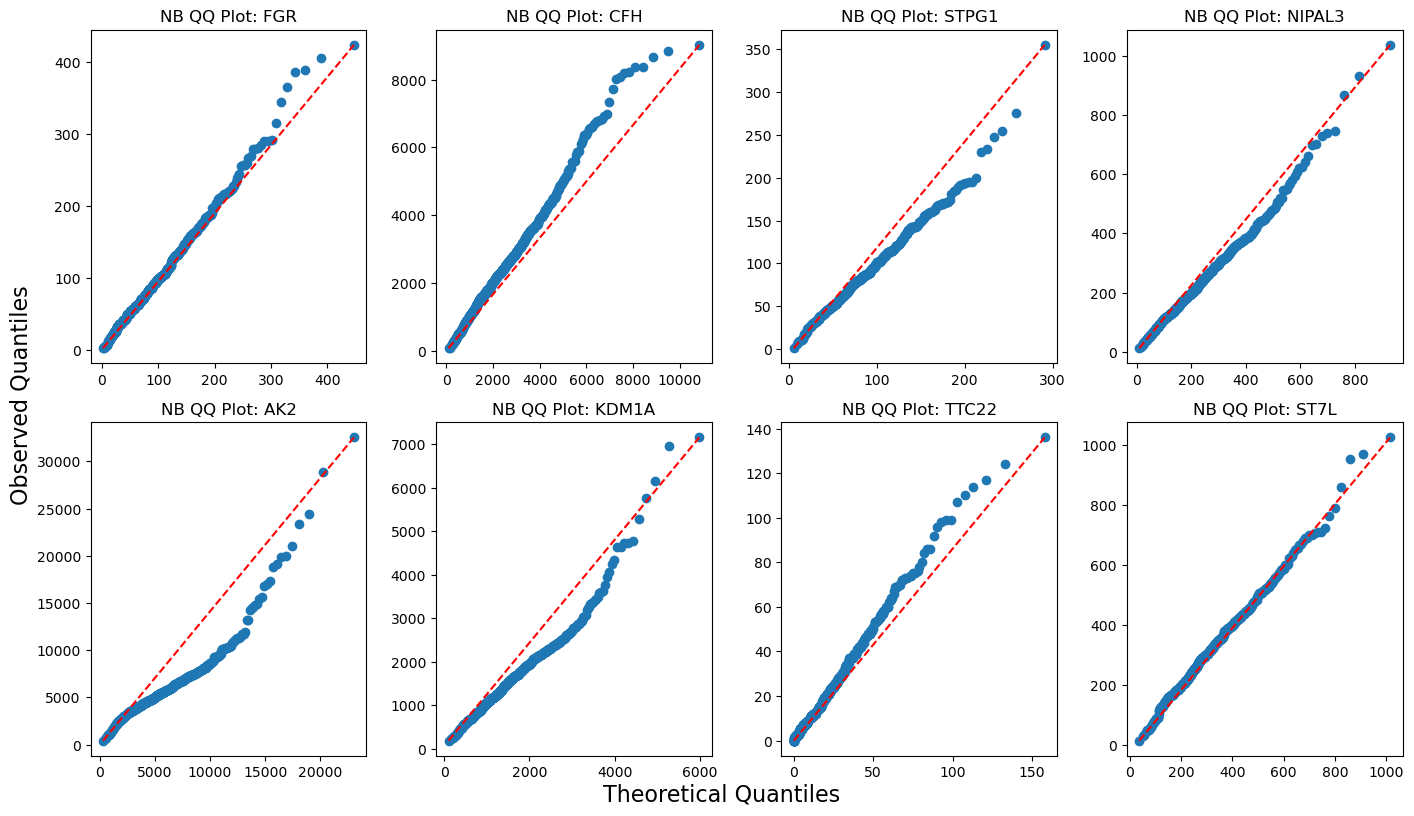

In [95]:
print ("NB: GSE167977")
qqplot_nb(tumours_counts)

Exponential: GSE167977


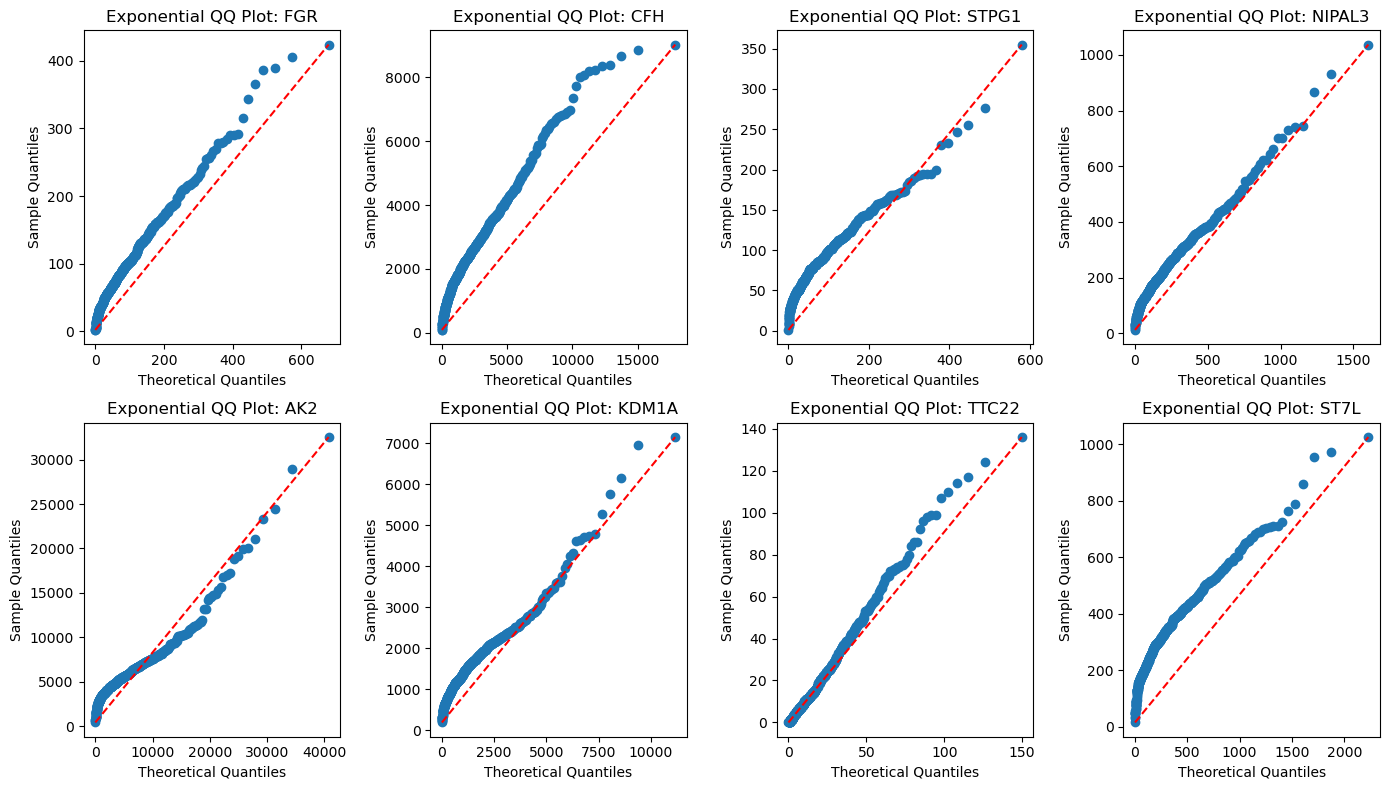

In [96]:
print ("Exponential: GSE167977")
qqplot_exp(tumours_counts)

In [97]:
# now DCIS Precise (loaded earlier)

NB: DCIS Precise


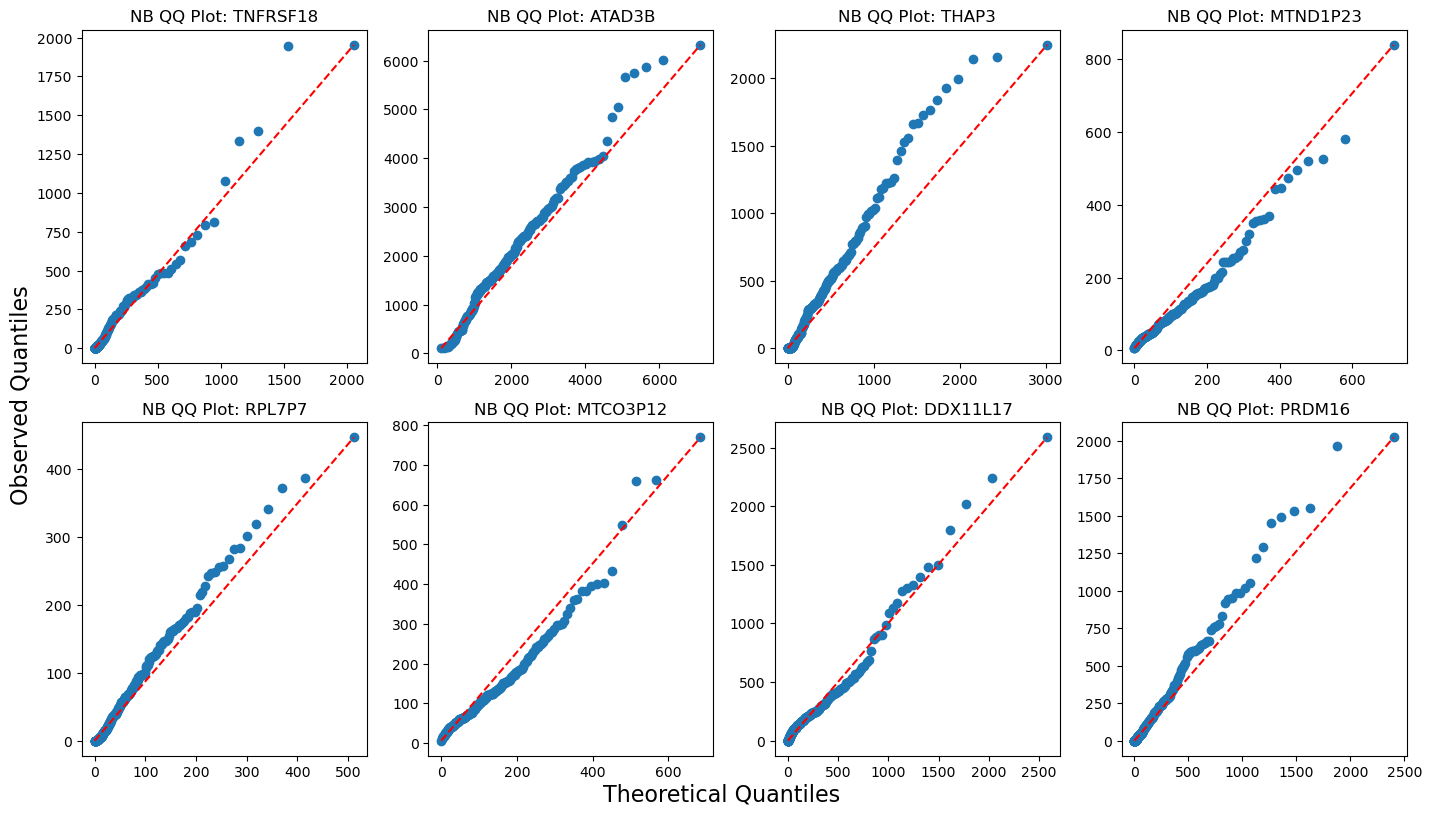

In [98]:
print ("NB: DCIS Precise")
qqplot_nb(count_DCIS)

Exp: DCIS Precise


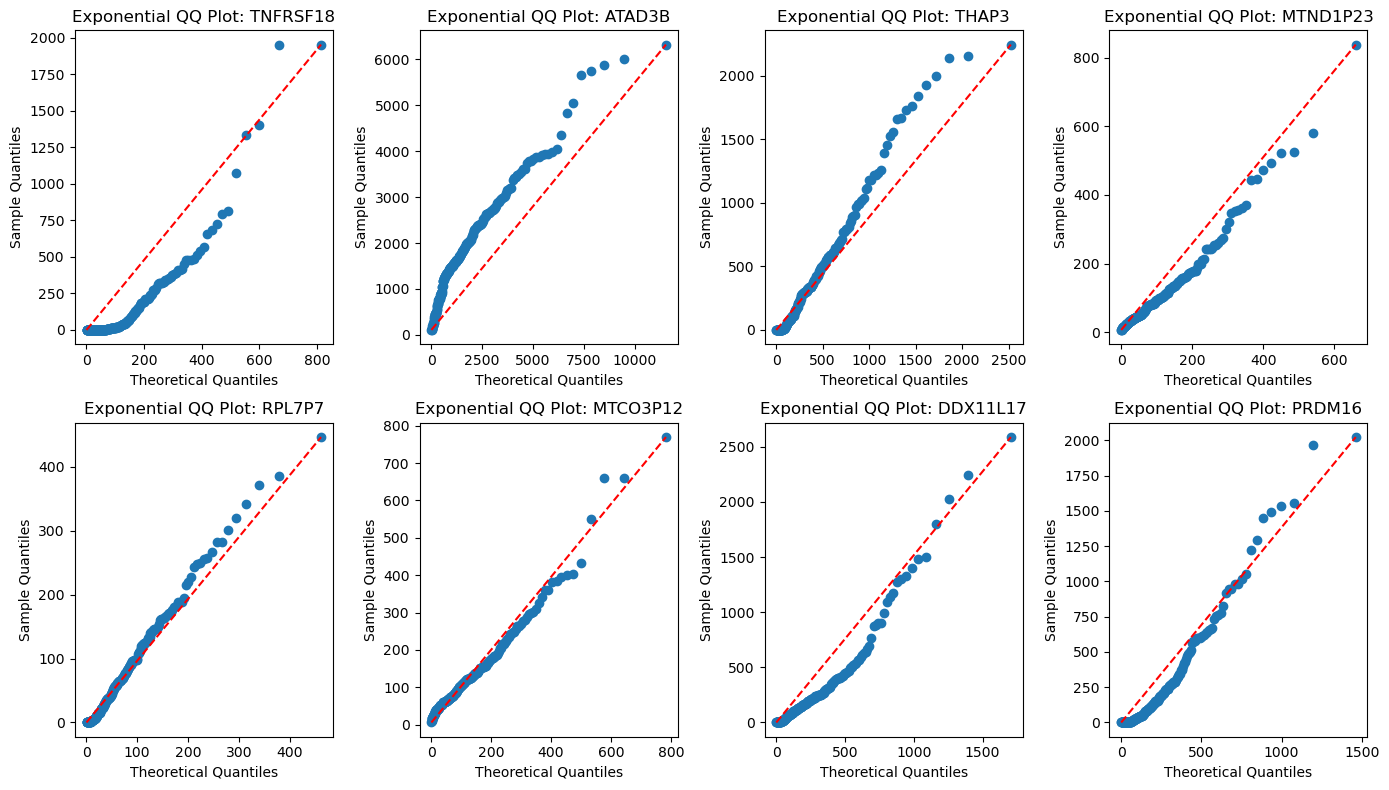

In [99]:
print ("Exp: DCIS Precise")
qqplot_exp(count_DCIS)